# CS445: Term Project

#### Victor Weeks & Josh Lutz

Note: I think I am going to explore changing my idea to taking current inventory info and deciding how best to make a profit

#### Get material data

In [47]:
import urllib.request, urllib.error, urllib.parse
api_key = "Bearer 51DD34C0-ABC4-E54C-A3F2-8E7500AE5F74705C18C6-B5BD-431A-8A6A-304EB4F2A24A"
headers = {'Authorization': api_key}

In [48]:
def getAccountMaterials():
        """Makes a request on the GW2 API."""
        url = 'https://api.guildwars2.com/v2/account/materials/'
        r = urllib.request.Request(url, headers=headers)
        if 'Cookie' not in headers:
            resp = urllib.request.urlopen(r)
            if 'set-cookie' in resp.headers:
                headers['Cookie'] = resp.headers['set-cookie'].split(';', 1)[0]
            return json.loads(resp.read())
        return json.loads(urllib.request.urlopen(r).read())

In [62]:
materials = getAccountMaterials()

In [70]:
materials[0]

{'category': 5, 'count': 56, 'id': 12134}

In [73]:
def saveMaterials(materials):
    playerMats = {}
    for mat in materials:        
        if mat['id'] in itemIDs:
            playerMats[mat['id']] = mat['count']
    with open('playerMaterials.txt', 'w') as outFile:
        json.dump(playerMats, outFile)

In [74]:
saveMaterials(materials)

In [76]:
matData = open('playerMaterials.txt')
matData = json.load(matData)
matData['19725']

151

## Introduction

In [1]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [2]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [40]:
from datetime import datetime

In [41]:
# This function adds current timepoint data to previous data and saves it
def saveItemTimepoint(itemIDs):
    now = datetime.now()
    allItems = np.load('itemData.npy')
    for id in itemIDs:
        item = spidy.getItemData(id)
        itemData = [item['data_id'], item['max_offer_unit_price'], item['min_sale_unit_price'], item['offer_availability'], item['sale_availability'], item['sale_price_change_last_hour'], item['offer_price_change_last_hour'],
                   now.year, now.month, now.day, now.hour, now.minute, now.second]
        allItems = np.vstack((allItems, itemData))
    np.save('itemData', allItems)
    print('Saved item data at : %s' % datetime.now())

In [42]:
saveItemTimepoint(itemIDs)

Saved item data at : 2018-05-05 17:59:01.579238


In [94]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(3927, 13)

In [16]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

#### Recurrent Neural Network

In [120]:
def makeItemData(itemID, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, :]
    T = itemData[stepsAheadToPredict:, :]
    plt.plot(X[:,1], 'o-', label='X')
    plt.plot(T[:,1], 'o-', label='T')
    plt.legend();
    return X, T

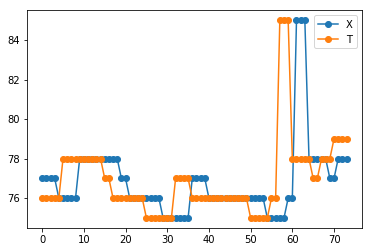

In [122]:
X, T = makeItemData(19718)

In [110]:
X = item1[:-5,:]
T = item1[5:,:]

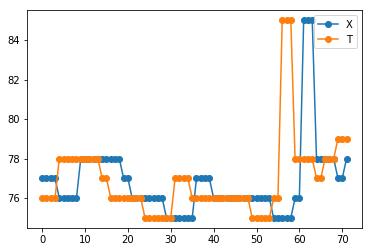

In [111]:
plt.plot(X[:,1], 'o-', label='X')
plt.plot(T[:,1], 'o-', label='T')
plt.legend();

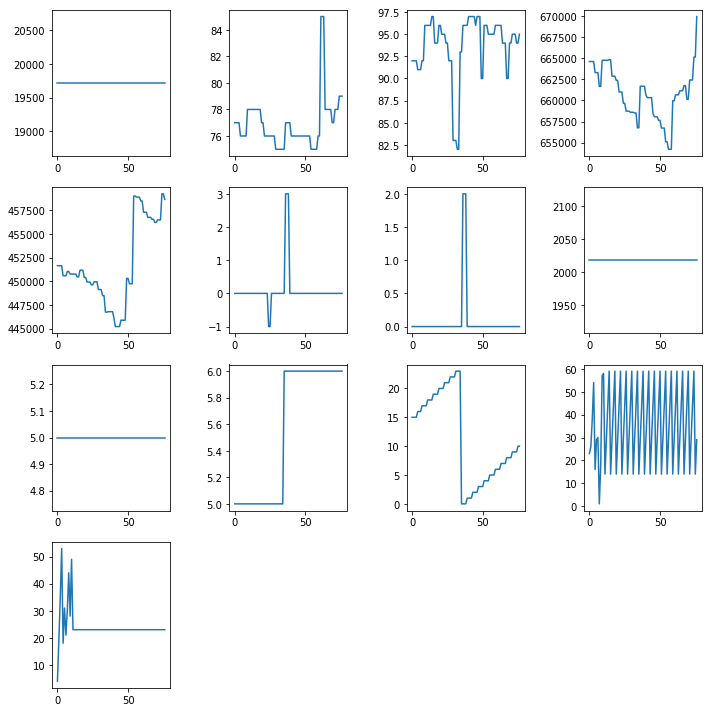

In [112]:
plt.figure(figsize=(10,10))
nrow, ncol = item1.shape
for c in range(ncol):
    plt.subplot(4, 4, c+1)
    plt.plot(item1[:, c])
    plt.tight_layout()

In [113]:
stepsToPredict = 2
T = item1[:-2, 1:2]
X = item1[2:, 2:]
Tname = names[1]
Xnames = names[2:]

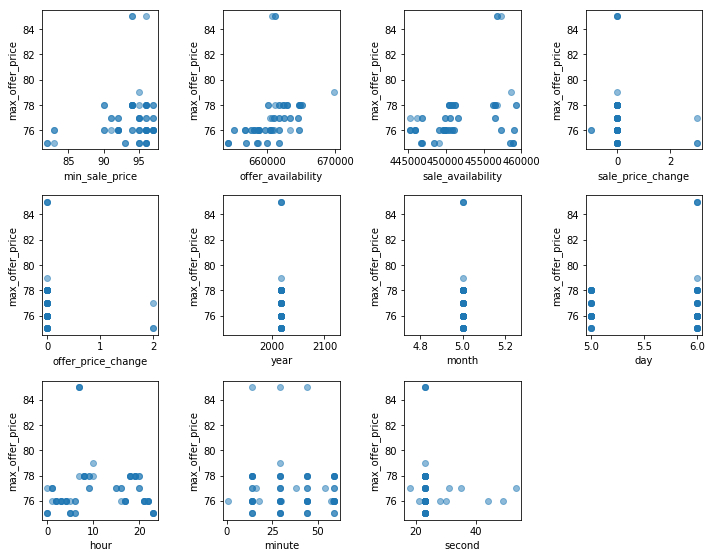

In [114]:
plt.figure(figsize=(10,10))
for c in range(X.shape[1]):
    plt.subplot(4, 4, c+1)
    plt.plot(X[:, c], T, 'o', alpha=0.5)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
    plt.tight_layout()

In [49]:
X1 = np.insert(X, 0, 1, 1)
X.shape, X1.shape

((1683, 11), (1683, 12))

In [50]:
Xnames.insert(0, 'bias')

In [51]:
Xnames

['bias',
 'min_sale_price',
 'offer_availability',
 'sale_availability',
 'sale_price_change',
 'offer_price_change',
 'year',
 'month',
 'day',
 'hour',
 'minute',
 'second']

In [52]:
nrows = X1.shape[0]
nTrain = int(round(nrow*0.8))
nTest = nrows - nTrain
nTrain, nTest, nTrain+nTest

(1346, 337, 1683)

In [53]:
rows = np.arange(nrows)
np.random.shuffle(rows)

In [54]:
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]

In [55]:
Xtrain = X1[trainIndices, :]
Ttrain = T[trainIndices, :]
Xtest = X1[testIndices, :]
Ttest = T[testIndices, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((1346, 12), (1346, 1), (337, 12), (337, 1))

In [56]:
hiddens = [20]
nnet = nn.NeuralNetwork(Xtrain.shape[1],hiddens,1)

nnet.train(Xtrain, Ttrain, nIterations=1000, verbose=True)
nnet

SCG: Iteration 100 fValue Eval 0.000595235655779 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.000548772600478 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.000542028216538 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.000536152550121 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.000532414028655 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.000529121022237 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.000526081687202 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.000523604652617 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.000520361939555 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.000518069003479 Scale 1e-15


NeuralNetwork(12, [20], 1)
   Network was trained for 1001 iterations that took 5.1904 seconds. Final error is 0.02276112922241196.

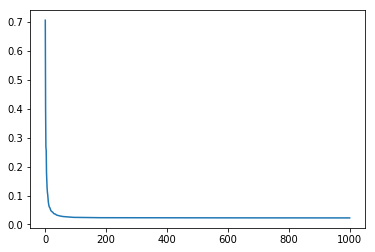

In [57]:
plt.plot(nnet.getErrors())

In [58]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [59]:
Ytrain = nnet.use(Xtrain)
Ytest = nnet.use(Xtest)
rmse(Ytrain, Ttrain), rmse(Ytest, Ttest)

(18.759095030531004, 20.762417694592525)

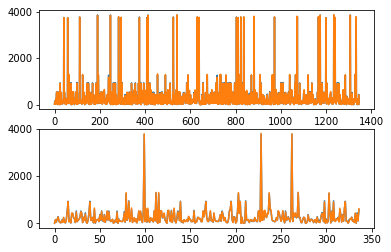

In [60]:
plt.subplot(2, 1, 1)
plt.plot(Ttrain)
plt.plot(Ytrain)
plt.subplot(2, 1, 2)
plt.plot(Ttest)
plt.plot(Ytest)

## Methods

Notes: 
* could seperate all items into train and test data
* could train on one item, test on another

In [41]:
# This method acts as the reinforcement and accounts for the 15% handling cost for selling items on the market
def checkForProfit(price_sold, price_bought):
    profit = (price_sold - (price_sold * 0.15)) - price_bought
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0

## Results

## Conclusions

## References